In [1]:
import os # need to happen before loading numpy
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8

In [79]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f
from on_manifold import OnManifoldExplainer, IndExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape, X_display.shape)
X.head()

(9932, 18) (9932, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [5]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=100)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model_train

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:7.26934
[100]	test-cox-nloglik:7.04554
[200]	test-cox-nloglik:6.90625
[300]	test-cox-nloglik:6.80909
[400]	test-cox-nloglik:6.73926
[500]	test-cox-nloglik:6.68686
[600]	test-cox-nloglik:6.64699
[700]	test-cox-nloglik:6.61571
[800]	test-cox-nloglik:6.59138
[900]	test-cox-nloglik:6.57148
[999]	test-cox-nloglik:6.55579


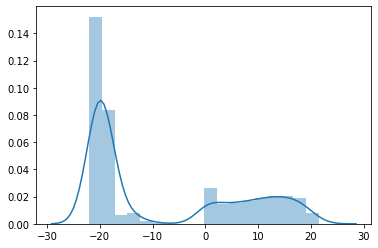

In [6]:
sns.distplot(y) # negative y are the censored y

In [7]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 1000, evals = [(xgb_full, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:8.88081
[999]	test-cox-nloglik:8.16748


In [8]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8289463410825477

# flat graph

In [32]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target
graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

0it [00:00, ?it/s]


In [33]:
nsamples = 100
explainer = GraphExplainer(graph, X, nruns=100) 
cf = explainer.shap_values(X[:nsamples])

bruteforce sampling: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


In [11]:
bg = shap.utils.sample(X, 100)
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False, output_margin=True), bg) # change to log(HR) with output_margin=True
shap_values = explainer(X[:100])

Permutation explainer: 101it [00:27,  3.72it/s]                         


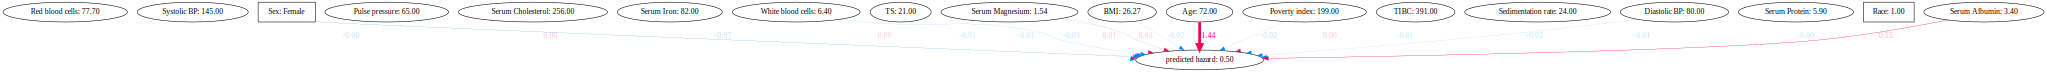

In [17]:
sample_ind = 60
cf.draw(sample_ind)

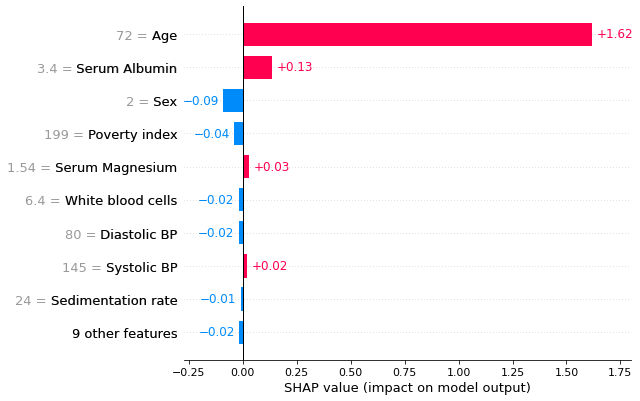

In [13]:
shap.plots.bar(shap_values[sample_ind])

In [14]:
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1]), output_margin=True)) # take the log

Age                    72.000000
Diastolic BP           80.000000
Poverty index         199.000000
Race                    1.000000
Red blood cells        77.700000
Sedimentation rate     24.000000
Serum Albumin           3.400000
Serum Cholesterol     256.000000
Serum Iron             82.000000
Serum Magnesium         1.540000
Serum Protein           5.900000
Sex                     2.000000
Systolic BP           145.000000
TIBC                  391.000000
TS                     21.000000
White blood cells       6.400000
BMI                    26.265815
Pulse pressure         65.000000
Name: 60, dtype: float64
target: [0.49635565]


# cluster graph

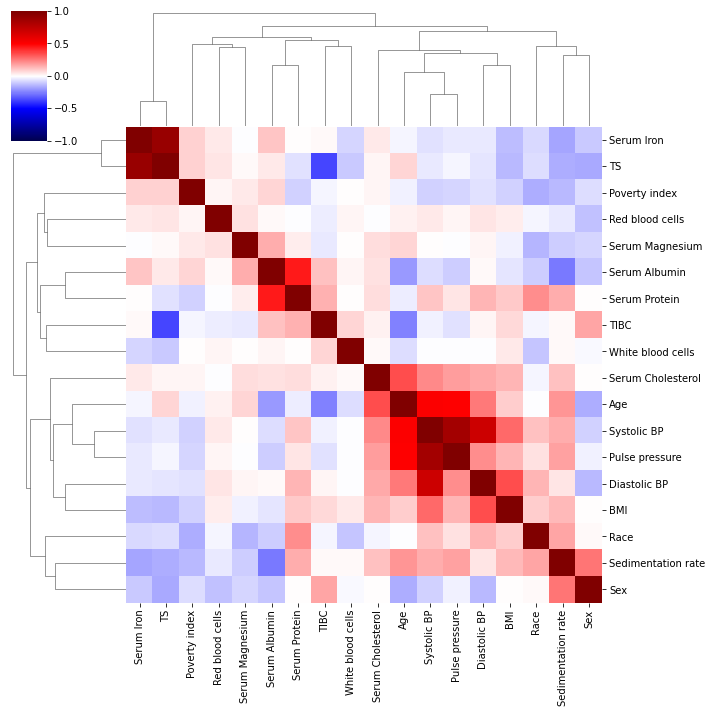

In [107]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=-1)

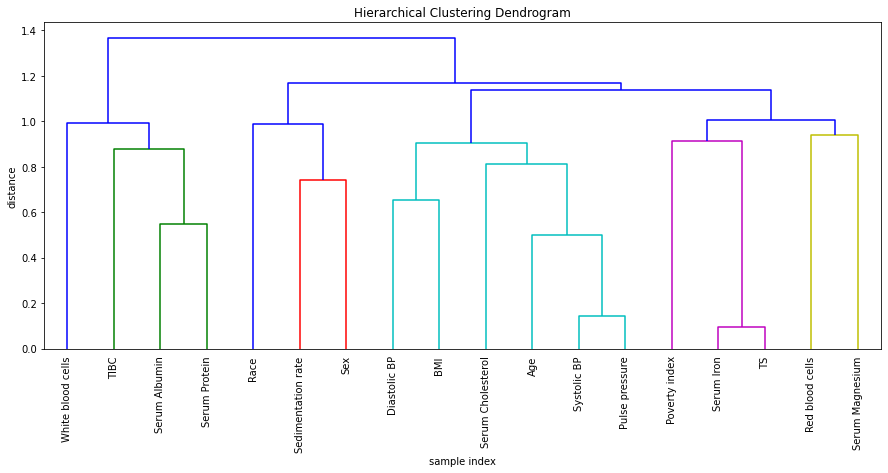

In [19]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

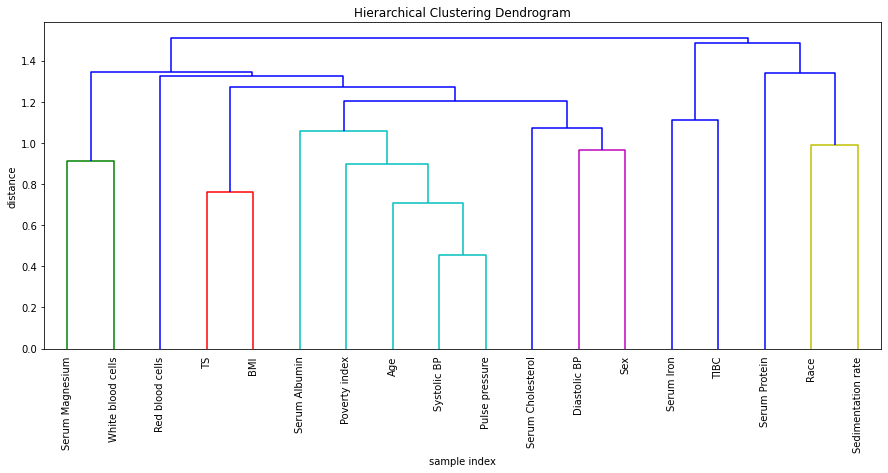

In [20]:
cluster_matrix_shap = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix_shap,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

In [24]:
E = GraphExplainer(graph, X[:1]) # only take one bg
E.prepare_graph(X[:nsamples])
cf_h = CreditFlow(hcluster_graph(E.graph, list(X.columns), cluster_matrix), nruns=-1)
cf_h.run(method='divide_and_conquer')

divide_and_conquer at level 0: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


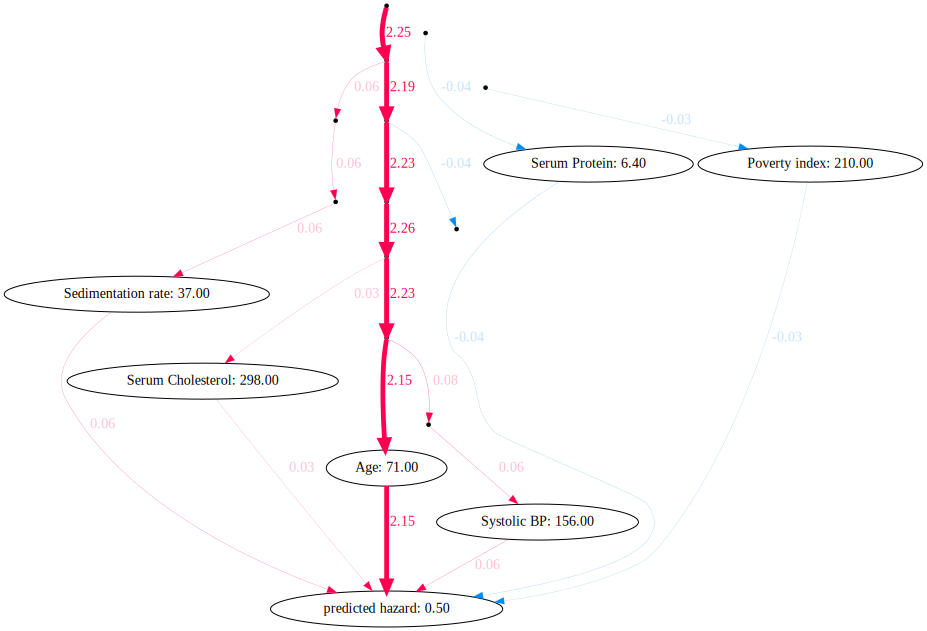

In [29]:
cf_h.draw(1, max_display=20)

In [26]:
#bg = shap.utils.sample(X, 300)
bg = np.vstack([X.iloc[0], X.iloc[0]])
masker = shap.maskers.TabularPartitions(bg)
masker.partition_tree = cluster_matrix
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False, output_margin=True), masker)
shap_values = explainer(X[:2])
explainer

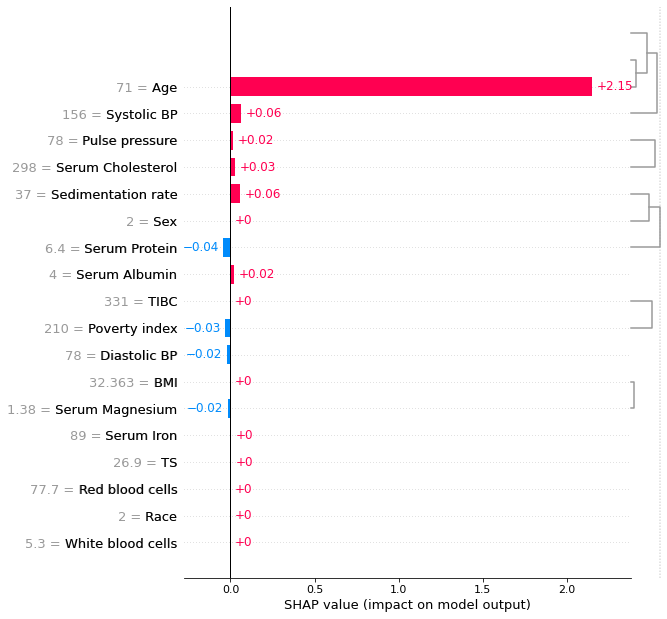

In [30]:
i = 1
shap.plots.bar(shap_values[i], clustering=cluster_matrix, cluster_threshold=0.9, max_display=20)
# shap.plots.waterfall(shap_values[i], max_display=20)

# On manifold

In [116]:
nsamples = 100
feature_names = X.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names)), output_margin=True)
explainer = OnManifoldExplainer(f, X.iloc[:100], nruns=100, sigma_sq=1e-1) 
cf_on_manifold = explainer.shap_values(X[:nsamples])

100%|██████████| 100/100 [06:39<00:00,  3.99s/it]


In [115]:
nsamples = 100
feature_names = X.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names)), output_margin=True)
explainer = IndExplainer(f, X.iloc[:100], nruns=100) 
cf_ind = explainer.shap_values(X[:nsamples])

# incorporate causal relationship

In [31]:
X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [59]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target uses log(HR) instead of HR
A = ['Diastolic BP', 'Systolic BP']
D = ['Pulse pressure'] # Systolic BP - Diastolic BP
causal_links.add_causes_effects(A, D, lambda dbp, sdp: sdp-dbp)
A = ['Age', 'Sex', 'Poverty index', 'Race']
D = list(set(feature_names) - set(A) - set(['Pulse pressure']))
causal_links.add_causes_effects(A, D)
A = ['Age', 'Sex', 'Race']
D = ['Poverty index']
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

learning dependency for TS:   0%|          | 0/14 [00:00<?, ?it/s]

[0]	test-rmse:29.79472
[100]	test-rmse:25.10775
[200]	test-rmse:21.40968
[300]	test-rmse:18.53344
[400]	test-rmse:16.33232
[499]	test-rmse:14.69491


learning dependency for Serum Protein:   7%|▋         | 1/14 [00:00<00:09,  1.31it/s]

[0]	test-rmse:6.61101
[100]	test-rmse:5.42027
[200]	test-rmse:4.44728
[300]	test-rmse:3.65282
[400]	test-rmse:3.00507
[499]	test-rmse:2.48216


learning dependency for White blood cells:  14%|█▍        | 2/14 [00:01<00:08,  1.48it/s]

[0]	test-rmse:7.24529
[100]	test-rmse:6.04540
[200]	test-rmse:5.08526
[300]	test-rmse:4.32187
[400]	test-rmse:3.72444
[499]	test-rmse:3.26567


learning dependency for Red blood cells:  21%|██▏       | 3/14 [00:01<00:07,  1.49it/s]  

[0]	test-rmse:56.62017
[100]	test-rmse:47.20332
[200]	test-rmse:39.64856
[300]	test-rmse:33.63278
[400]	test-rmse:28.88807
[499]	test-rmse:25.23218


learning dependency for Sedimentation rate:  29%|██▊       | 4/14 [00:02<00:06,  1.57it/s]

[0]	test-rmse:19.38453
[100]	test-rmse:16.95487
[200]	test-rmse:15.09857
[300]	test-rmse:13.70687
[400]	test-rmse:12.67748
[499]	test-rmse:11.94172


learning dependency for Serum Cholesterol:  36%|███▌      | 5/14 [00:03<00:05,  1.58it/s] 

[0]	test-rmse:226.94263
[100]	test-rmse:187.87550
[200]	test-rmse:156.24817
[300]	test-rmse:130.78793
[400]	test-rmse:110.44482
[499]	test-rmse:94.44800


learning dependency for Serum Iron:  43%|████▎     | 6/14 [00:03<00:04,  1.61it/s]       

[0]	test-rmse:105.80270
[100]	test-rmse:88.86579
[200]	test-rmse:75.45216
[300]	test-rmse:64.97789
[400]	test-rmse:56.92674
[499]	test-rmse:50.90213


learning dependency for Serum Magnesium:  50%|█████     | 7/14 [00:04<00:04,  1.64it/s]

[0]	test-rmse:1.18907
[100]	test-rmse:0.97714
[200]	test-rmse:0.80443
[300]	test-rmse:0.66402
[400]	test-rmse:0.55023
[499]	test-rmse:0.45920


learning dependency for Poverty index:  57%|█████▋    | 8/14 [00:04<00:03,  1.82it/s]  

[0]	test-rmse:365.16959
[100]	test-rmse:325.23489
[200]	test-rmse:295.42529
[300]	test-rmse:273.60980
[400]	test-rmse:257.95938
[499]	test-rmse:247.04848


learning dependency for Diastolic BP:  64%|██████▍   | 9/14 [00:05<00:02,  1.90it/s] 

[0]	test-rmse:83.71988
[100]	test-rmse:68.93323
[200]	test-rmse:56.90493
[300]	test-rmse:47.15287
[400]	test-rmse:39.27799
[499]	test-rmse:33.00833


learning dependency for Serum Albumin:  71%|███████▏  | 10/14 [00:05<00:02,  1.90it/s]

[0]	test-rmse:3.87407
[100]	test-rmse:3.17810
[200]	test-rmse:2.60949
[300]	test-rmse:2.14547
[400]	test-rmse:1.76748
[499]	test-rmse:1.46278


learning dependency for Systolic BP:  79%|███████▊  | 11/14 [00:06<00:01,  2.01it/s]  

[0]	test-rmse:136.18751
[100]	test-rmse:112.07594
[200]	test-rmse:92.46082
[300]	test-rmse:76.55484
[400]	test-rmse:63.71541
[499]	test-rmse:53.49734


learning dependency for TIBC:  86%|████████▌ | 12/14 [00:06<00:01,  1.94it/s]       

[0]	test-rmse:365.08758
[100]	test-rmse:300.40857
[200]	test-rmse:247.82375
[300]	test-rmse:205.21208
[400]	test-rmse:170.85915
[499]	test-rmse:143.55504


learning dependency for BMI:  93%|█████████▎| 13/14 [00:07<00:00,  1.96it/s] 

[0]	test-rmse:25.68026
[100]	test-rmse:21.22700
[200]	test-rmse:17.61862
[300]	test-rmse:14.70853
[400]	test-rmse:12.38153
[499]	test-rmse:10.55001


learning dependency for BMI: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


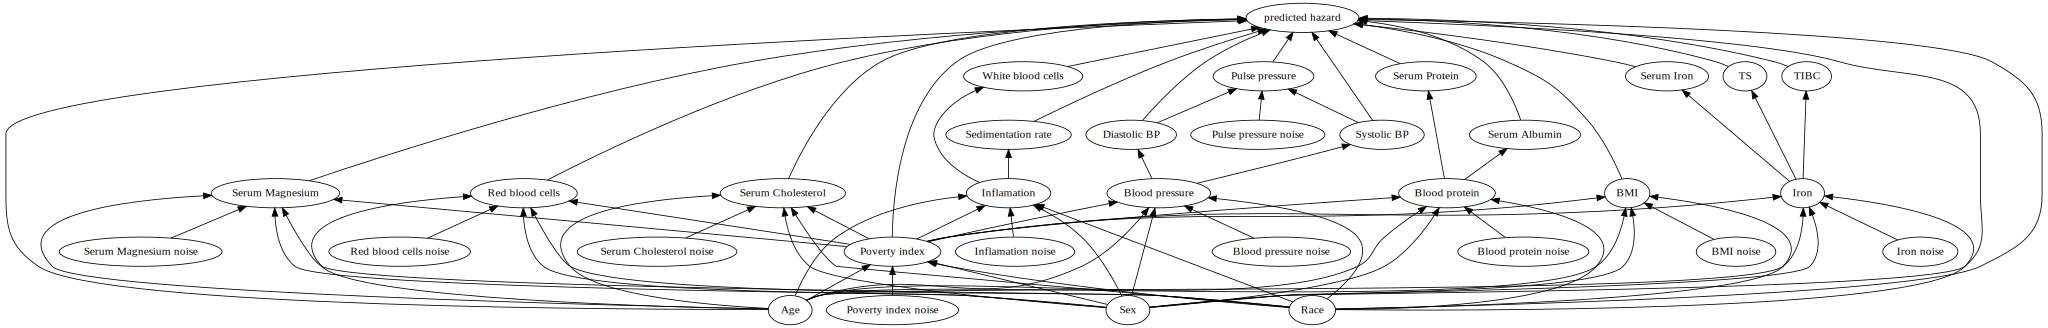

In [60]:
G.draw()

In [52]:
save_graph(G.to_graphviz(), 'nutrition_causal_graph.png')

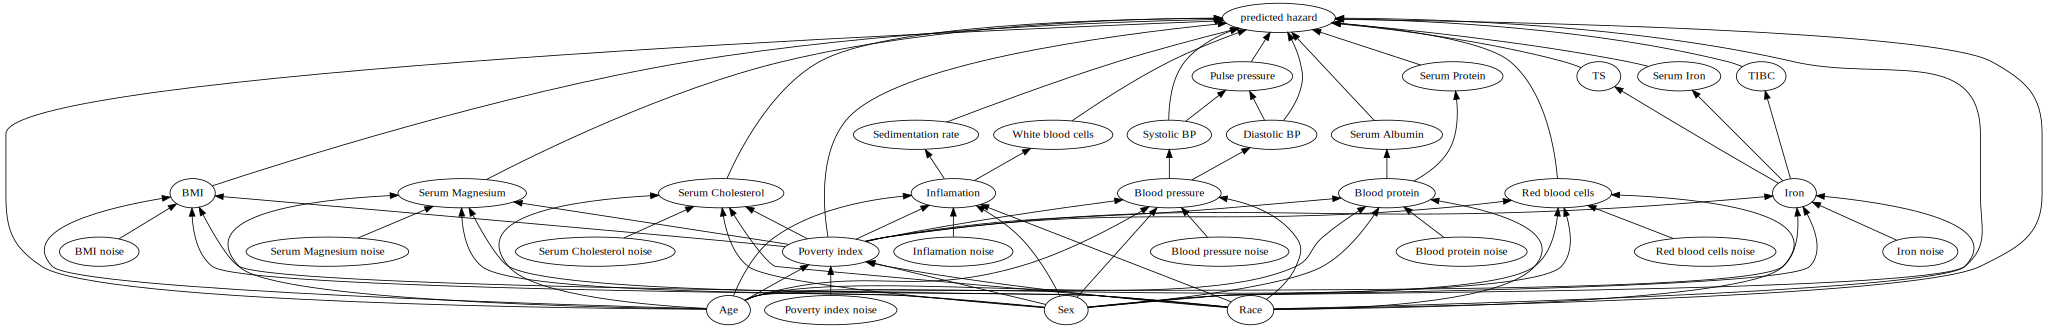

In [61]:
# for multiple baseline need to run this multiple times, finally I can just combine the different baselines because of linearity
E = GraphExplainer(causal_graph, X)
E.prepare_graph(X) # add noise node
G = copy.deepcopy(E.graph)
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

In [62]:
cf_c = GraphExplainer(G, X, nruns=100).shap_values(X[:100], skip_prepare=True) # skip prepare b/c already prepared the noise and samplers

bruteforce sampling: 100%|██████████| 100/100 [16:26<00:00,  9.86s/it]


In [64]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model, output_margin=True)) # the target
graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

# get interpretation
nsamples = 100
explainer = GraphExplainer(graph, X, nruns=100) 
cf = explainer.shap_values(X[:nsamples])

0it [00:00, ?it/s]
bruteforce sampling: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


# investigate the background and foreground samples

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
55,42.0,92.0,248.0,1.0,77.7,16.0,4.5,250.0,114.0,1.63,7.8,2.0,136.0,307.0,37.1,9.5,22.576241,44.0


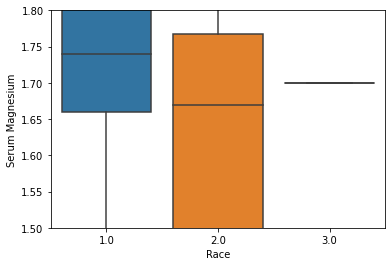

In [254]:
sample_ind = 55 # 55, 66, 3, 22, 33
ax = sns.boxplot(x="Race", y="Serum Magnesium", data=X[:nsamples])
plt.ylim(1.5, 1.8)
X.iloc[[0, sample_ind]]

In [255]:
X[X['Race']==1]['Serum Magnesium'].mean() - X[X['Race']==2]['Serum Magnesium'].mean()

0.06555192965322076

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
55,42.0,92.0,248.0,1.0,77.7,16.0,4.5,250.0,114.0,1.63,7.8,2.0,136.0,307.0,37.1,9.5,22.576241,44.0


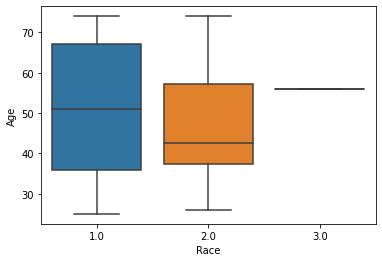

In [253]:
sample_ind = 55 # 55, 66, 3, 22, 33
ax = sns.boxplot(x="Race", y="Age", data=X[:nsamples])
# plt.ylim(1.5, 1.8)
X.iloc[[0, sample_ind]]

In [235]:
print(X.iloc[[0, sample_ind]].loc[:, ['Age', 'Serum Magnesium', 'Race']].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   Age &  Serum Magnesium &  Race \\
\midrule
0  &  35.0 &             1.37 &   2.0 \\
55 &  42.0 &             1.63 &   1.0 \\
\bottomrule
\end{tabular}



When race changes from 2 to 1, magnesium changes back, serum magnesium is expected to increase, which account for the change in output.

# Comparison of methods

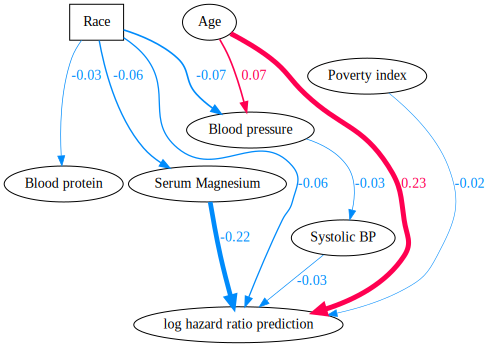

In [257]:
sample_ind = 55 # 55, 66, 3, 22, 33
cf_c.fold_noise = True # False
target_node = [node for node in cf_c.graph if node.is_target_node][0]
target_node.name = 'log hazard ratio prediction'
g = cf_c.draw(sample_ind, max_display=10, show_fg_val=False)
save_graph(g, f'figures/nutrition_flow_{sample_ind}.png')

ASV


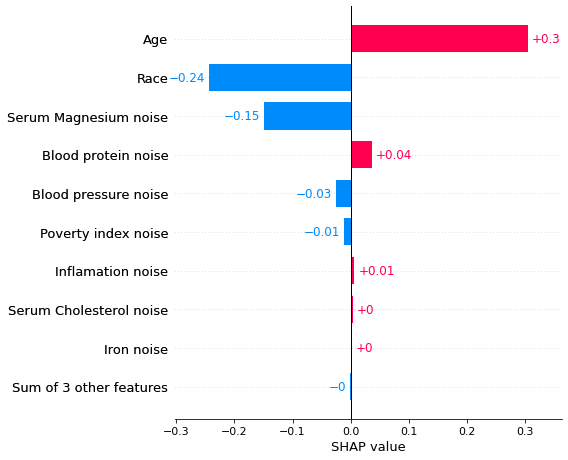

In [245]:
# asv
print('ASV')
def prepare_bar_asv(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_c.graph if i.is_target_node][0]
edge_credit = cf_c.get_asv_edge_credit(sample_ind)

b = prepare_bar_asv(target_node, edge_credit, sample_ind)
shap.plots.bar(b, max_display=10, show=False)
plt.tight_layout()
plt.savefig(f'figures/nutrition_asv_{sample_ind}.png')
plt.show()

# cf_c.fold_noise = False
# g = cf_c.draw_asv(sample_ind, max_display=5)
# save_graph(g, f'figures/nutrition_asv_{sample_ind}.png')

Independent


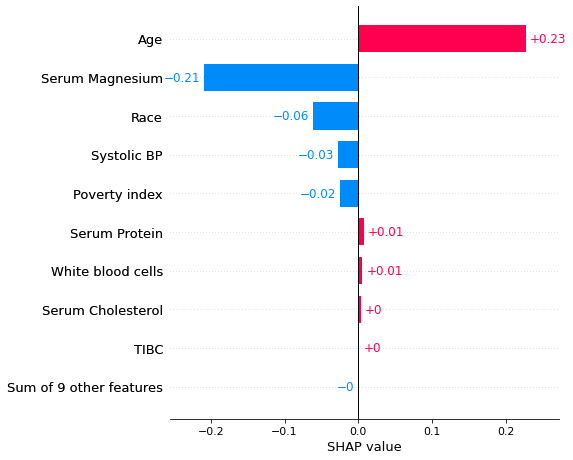

In [246]:
# shap
print('Independent')
def prepare_bar_shap(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node][sample_ind] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None # np.arange(len(b.input_names))
    b.transform_history = []
    return b


target_node = [i for i in cf.graph if i.is_target_node][0]
edge_credit = cf.edge_credit

b = prepare_bar_shap(target_node, edge_credit, sample_ind)
shap.plots.bar(b, max_display=10, show=False)
plt.tight_layout()
plt.savefig(f'figures/nutrition_shap_{sample_ind}.png')
plt.show()

# g = cf.draw(idx=sample_ind, max_display=5)
# save_graph(g, f'figures/nutrition_shap_{sample_ind}.png')

On manifold


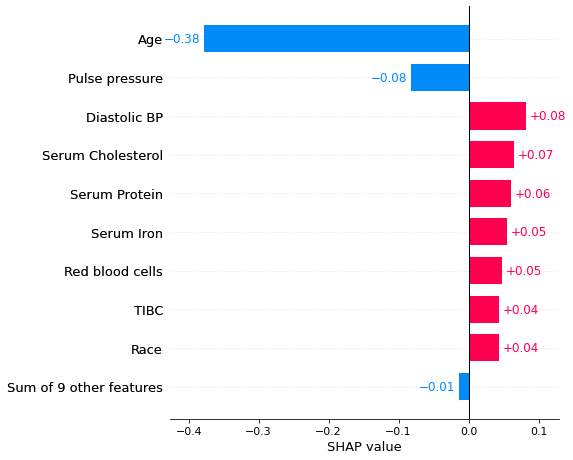

In [247]:
print('On manifold')
cf_on_manifold.draw(sample_ind, show=False, max_display=10)
plt.tight_layout()
plt.savefig(f'figures/nutrition_manifold_{sample_ind}.png')
plt.show()

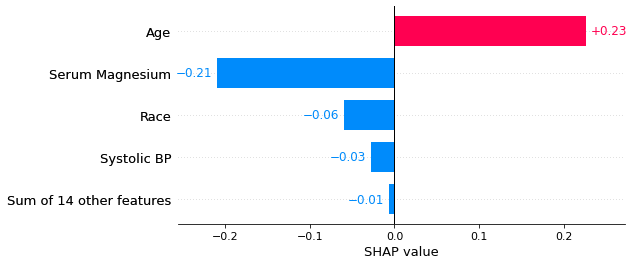

In [248]:
cf_ind.draw(sample_ind, max_display=5)

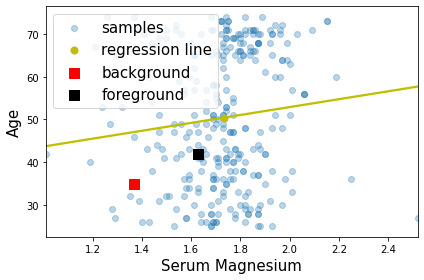

In [270]:
nsamples = 300
o = f(np.array(X)[:nsamples])
def normalize(o): # normalize to 0-1
    return (o - o.min()) / (o.max() - o.min())

xlabel = 'Serum Magnesium' # 'Serum Magnesium' # 'TIBC' #'Red blood cells' # 'Serum Iron' # 'Serum Protein' # 'Serum Cholesterol' # 'Diastolic BP'
ylabel = 'Age'

# xlabel = 'Age'
# ylabel = 'Serum Magnesium'

plt.scatter(X[xlabel][:nsamples], X[ylabel][:nsamples], #c=normalize(o), 
            alpha=0.3, label='samples')
sns.regplot(X[xlabel][:nsamples], X[ylabel][:nsamples], x_bins=1, order=1, ci=None, label='regression line', color='y')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

plt.scatter(X[xlabel][[0]], X[ylabel][[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], X[ylabel][[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15, loc="upper left")

plt.tight_layout()
plt.savefig(f'figures/manifold_explain_age_{xlabel}.png')
plt.show()

This is a clear example of why on manifold perturabtion can be extremely misleading! Given Serum Magnesium level of 1.6, the algorithm expect an age of near 50, but when the actual age is revealed, we see a pleasant surprise that lowers the risk! But Age certainty is not a protective attribute! ASV and Flow wouldn't try this order (Serum Magnesium followed by Age).

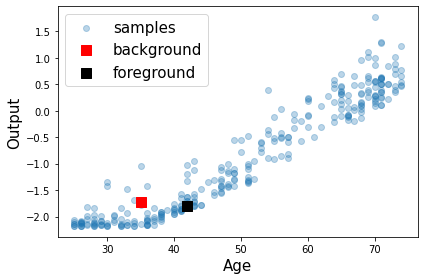

In [260]:
nsamples = 300
o = f(np.array(X)[:nsamples])

xlabel = 'Age'
ylabel = 'Output'
plt.scatter(X[xlabel][:nsamples], o, alpha=0.3, label='samples')
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.scatter(X[xlabel][[0]], o[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('figures/manifold_age.png')
plt.show()

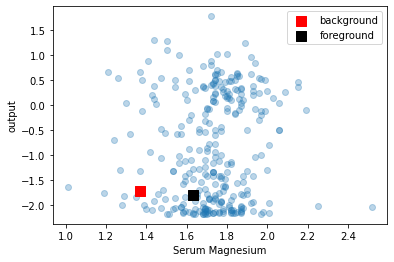

In [181]:
nsamples = 300
o = f(np.array(X)[:nsamples])

xlabel = 'Serum Magnesium'
ylabel = 'output'
plt.scatter(X[xlabel][:nsamples], o, alpha=0.3)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.scatter(X[xlabel][[0]], o[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend()

In [128]:
X_display.iloc[0]

Age                        35
Diastolic BP               92
Poverty index             126
Race                        2
Red blood cells          77.7
Sedimentation rate         12
Serum Albumin               5
Serum Cholesterol         165
Serum Iron                135
Serum Magnesium          1.37
Serum Protein             7.6
Sex                    Female
Systolic BP               142
TIBC                      323
TS                       41.8
White blood cells         5.8
BMI                   31.1094
Pulse pressure             50
Name: 0, dtype: object

In [129]:
X_display.iloc[sample_ind]

Age                        42
Diastolic BP               92
Poverty index             248
Race                        1
Red blood cells          77.7
Sedimentation rate         16
Serum Albumin             4.5
Serum Cholesterol         250
Serum Iron                114
Serum Magnesium          1.63
Serum Protein             7.8
Sex                    Female
Systolic BP               136
TIBC                      307
TS                       37.1
White blood cells         9.5
BMI                   22.5762
Pulse pressure             44
Name: 55, dtype: object

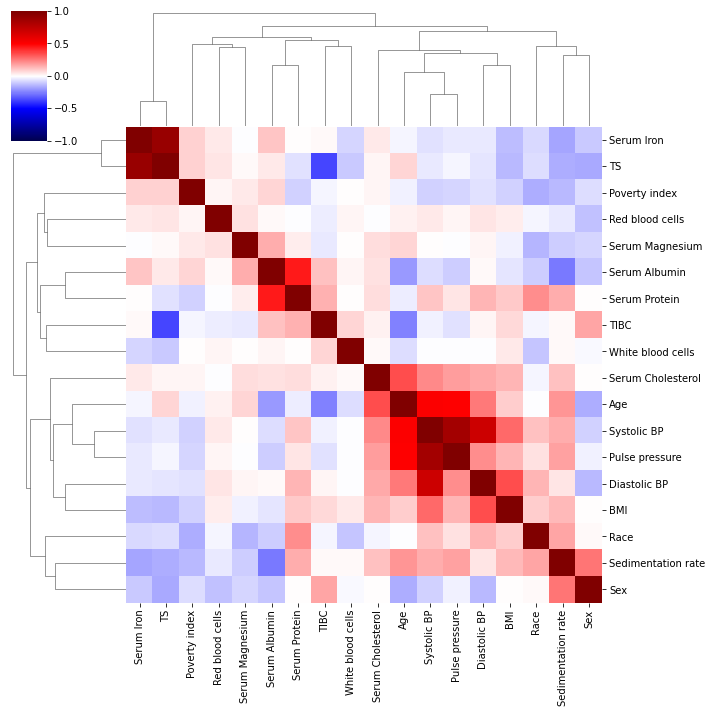

In [119]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=-1)

# Output to latex

In [196]:
latex_dict = {}

# asv
def prepare_bar_asv(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_c.graph if i.is_target_node][0]
edge_credit = cf_c.get_asv_edge_credit(sample_ind)
b = prepare_bar_asv(target_node, edge_credit, sample_ind)
latex_dict['asv'] = {k:v for k,v in zip(map(lambda n: n[:-6] if n[-5:] == 'noise' else n,
                                            b.input_names), 
                                        b.values)}

# shap
def prepare_bar_shap(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node][sample_ind] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None # np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf.graph if i.is_target_node][0]
edge_credit = cf.edge_credit
b = prepare_bar_shap(target_node, edge_credit, sample_ind)
latex_dict['ind'] = {k:v for k,v in zip(b.input_names, b.values)}

# on manifold
def prepare_on_manifold(cf, sample_ind):
    class D(): pass
    b.input_names = cf.input_names
    b.values = cf.values[sample_ind]
    return b

b = prepare_on_manifold(cf_on_manifold, sample_ind)
latex_dict['manifold'] = {k:v for k,v in zip(b.input_names, b.values)}

# resulting data frame
df = pd.DataFrame.from_dict(latex_dict).loc[:, ['ind', 'manifold', 'asv']]
df.loc[:, 'asv'] = df.loc[:, 'asv'].fillna(0)
print(df.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   ind &  manifold &   asv \\
\midrule
Race               & -0.06 &      0.04 & -0.24 \\
Blood pressure     &   NaN &       NaN & -0.03 \\
Age                &  0.23 &     -0.38 &  0.30 \\
Inflamation        &   NaN &       NaN &  0.01 \\
Sex                &  0.00 &      0.02 &  0.00 \\
Serum Magnesium    & -0.21 &     -0.02 & -0.15 \\
BMI                & -0.00 &     -0.03 & -0.00 \\
Poverty index      & -0.02 &      0.01 & -0.01 \\
Serum Cholesterol  &  0.00 &      0.07 &  0.00 \\
Blood protein      &   NaN &       NaN &  0.04 \\
Iron               &   NaN &       NaN &  0.00 \\
Red blood cells    &  0.00 &      0.05 &  0.00 \\
Sedimentation rate &  0.00 &      0.01 &  0.00 \\
Diastolic BP       &  0.00 &      0.08 &  0.00 \\
Serum Albumin      &  0.00 &     -0.01 &  0.00 \\
Serum Protein      &  0.01 &      0.06 &  0.00 \\
TS                 &  0.00 &      0.03 &  0.00 \\
Pulse pressure     &  0.00 &     -0.08 &  0.00 \\
White blood cells  &  0.01

In [197]:
colors = np.array(df.fillna(0))

# normalize each column by the largest absolute value
for i in range(colors.shape[1]):
    colors[:, i] /= np.abs(colors[:, i]).max()
    colors[:, i] *= 100
colors = colors.astype(np.int)

# sort index by its abs score across columns
feature_order = np.abs(colors).sum(1).argsort()[::-1]
colors

array([[ -26,   11,  -80],
       [   0,    0,   -8],
       [ 100, -100,  100],
       [   0,    0,    2],
       [   0,    4,    0],
       [ -92,   -4,  -48],
       [   0,   -7,    0],
       [ -10,    1,   -3],
       [   1,   17,    1],
       [   0,    0,   11],
       [   0,    0,    0],
       [   0,   12,    0],
       [   0,    2,    0],
       [   0,   21,    0],
       [   0,   -3,    0],
       [   3,   15,    0],
       [   0,    7,    0],
       [   0,  -21,    0],
       [   2,   -1,    0],
       [   0,   11,    0],
       [   0,   14,    0],
       [ -12,   -1,    0]])

In [198]:
table = "\\begin{tabular}{lrrr}\n\\toprule\n"
table += r"{} & Independent & On-manifold & ASV\\"
table += "\n\\midrule\n"
for i in feature_order:
    row = []
    feature_name = df.iloc[i].name
    row.append(feature_name)
    for j in range(colors.shape[1]):
        v = df.iloc[i, j].round(2)
        c = "blue" if colors[i, j] < 0 else "red"
        c = f"\\cellcolor{{{c}!{np.abs(colors[i,j])}}}"
        row.append(f"{c} {v}")
    table += r" & ".join(row)
    table += "\\\\\n"
table += "\\bottomrule\n\\end{tabular}"
print(table)

\begin{tabular}{lrrr}
\toprule
{} & Independent & On-manifold & ASV\\
\midrule
Age & \cellcolor{red!100} 0.23 & \cellcolor{blue!100} -0.38 & \cellcolor{red!100} 0.3\\
Serum Magnesium & \cellcolor{blue!92} -0.21 & \cellcolor{blue!4} -0.02 & \cellcolor{blue!48} -0.15\\
Race & \cellcolor{blue!26} -0.06 & \cellcolor{red!11} 0.04 & \cellcolor{blue!80} -0.24\\
Pulse pressure & \cellcolor{red!0} 0.0 & \cellcolor{blue!21} -0.08 & \cellcolor{red!0} 0.0\\
Diastolic BP & \cellcolor{red!0} 0.0 & \cellcolor{red!21} 0.08 & \cellcolor{red!0} 0.0\\
Serum Cholesterol & \cellcolor{red!1} 0.0 & \cellcolor{red!17} 0.07 & \cellcolor{red!1} 0.0\\
Serum Protein & \cellcolor{red!3} 0.01 & \cellcolor{red!15} 0.06 & \cellcolor{red!0} 0.0\\
Serum Iron & \cellcolor{red!0} 0.0 & \cellcolor{red!14} 0.05 & \cellcolor{red!0} 0.0\\
Poverty index & \cellcolor{blue!10} -0.02 & \cellcolor{red!1} 0.01 & \cellcolor{blue!3} -0.01\\
Systolic BP & \cellcolor{blue!12} -0.03 & \cellcolor{blue!1} -0.01 & \cellcolor{red!0} 0.0\\


# Some next steps

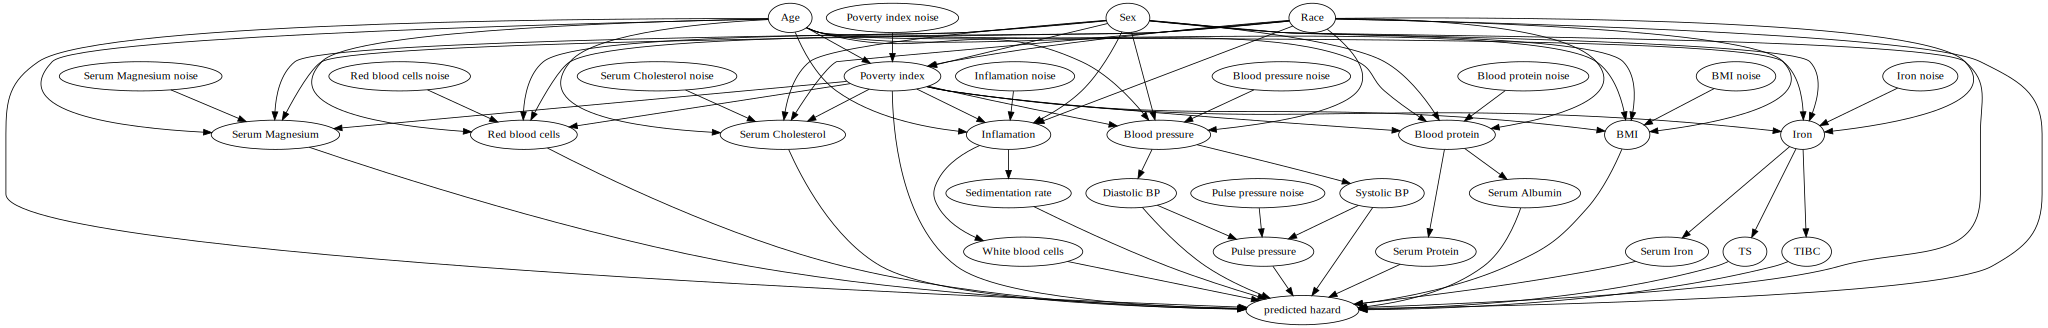

In [28]:
# these are additional steps to give the graph structure and I need to do this for every iteration!
E = GraphExplainer(causal_graph, X)
E.prepare_graph(X) # add noise node
G = copy.deepcopy(E.graph)
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

In [185]:
import dill
# dill.dump(cf, open('NHANES1_cf_ind.pkl', 'wb'))
# dill.dump(cf_c, open('NHANES1_cf_flow.pkl', 'wb'))
# dill.dump(cf_on_manifold, open('NHANES1_cf_manifold.pkl', 'wb'))

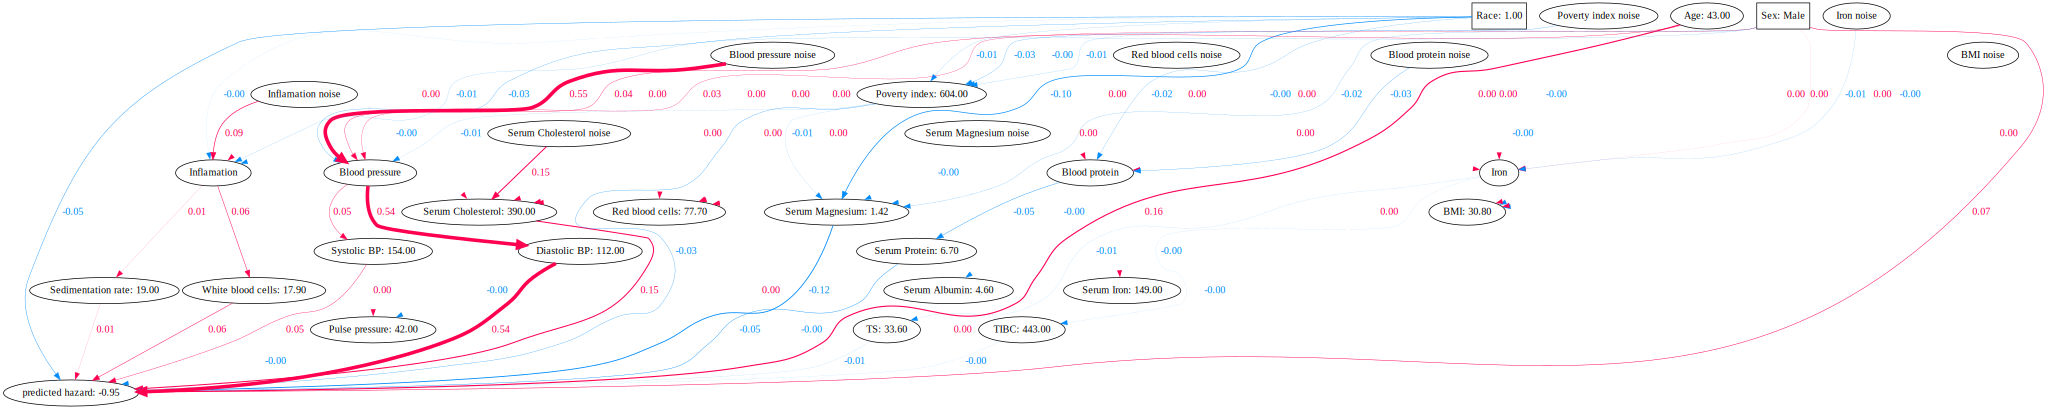

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fc72ddc37b0>>

In [186]:
dill.load(open('NHANES1_cf_flow.pkl', 'rb')).draw(66)